<a href="https://colab.research.google.com/github/bzimons/mvp_puc_2/blob/main/mvp2_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Análise de Dados e Boas Práticas
## Aluna: Beatriz Leal Simões e Silva


## 1. Definição do Problema

O dataset escolhido para a realização deste trabalho é sobre composição e tipos de vidro, disponibilizados pelo Serviço de Ciência Forense dos EUA. No dataset, encontramos 6 tipos de vidro que são definidos em termos de seu teor de óxido ou seja, Na, Fe, K, etc.

O dataset é composto dos seguintes atributos:

1.  **Type_of_glass**: Tipo do vidro (1, 2, 3, 5, 6 e 7)
  - tipo 1: Janela para edifícios processada
  - tipo 2: Janela para edifícios não processada
  - tipo 3: Janela para veículo processada
  - tipo 4: (Não disponível nessa base)
  - tipo 5: recipientes
  - tipo 6: utensílios de cozinha
  - tipo 7: Lâmpadas
2.  **RI**: Indice de refração
3.  **Mg**: Magnésio
4.  **Al**: Alumínio
5.  **Si**: Sílica
6.  **K**: Potássio
7.  **Ca**: Cálcio
8.  **Ba**:Bário
9.  **Fe**:  Ferro


O objetivo principal aqui será dividir o dataset entre treino e teste e utilizar modelos Machine  Learning para classificar a observação (vidro) em uma das categorias da melhor maneira possível.

Porém, além disso, no site em que o dataset se encontra, temos disponível uma relação de modelos já utilizados para a classificação deste dataset:

![](https://raw.githubusercontent.com/bzimons/mvp_puc_2/master/imagens/baseline_models_glass.PNG)

Portanto, para aproveitar também esta informação, os modelos escolhidos serão os modelos já utilizados neste gráfico disponibilizado, com exceção da rede neural. Ou seja, iremos trabalhar com os modelos XGBoost,SVM, Random Forest e Regressão Logística.

Os dados foram obtidos no site da *UCI Machine Learning Repository*, o link de acesso da base e as demais fontes do trabalho estarão disponíveis ao final do MVP.




In [1]:
# importando as bibliotecas:
import pandas as pd
import numpy as np

from plotnine import ggplot, aes, geom_line, geom_point, xlim, ylim, geom_jitter, geom_abline, theme_set, theme_bw, geom_histogram, geom_bar, ylab, scale_colour_manual,theme,labs
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold,train_test_split , cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
np.set_printoptions(precision=2)

In [2]:
# definindo funções:
def forward_selection(X, y, model):
    '''
    Função foward para a seleção de Features
    y: variável resposta
    X: varíáveis explicativas
    model: modelo utilizado
    '''
    selected_features = []
    best_score = 0
    while True:
        scores = []
        for feature in X.columns:
            if feature not in selected_features:
                features_to_try = selected_features + [feature]
                score = cross_val_score(model, X[features_to_try], y, cv=5).mean()
                scores.append((score, feature))
        scores.sort(reverse=True)
        new_score, new_feature = scores[0]
        if new_score > best_score:
            selected_features.append(new_feature)
            best_score = new_score
        else:
            break
    return print("Variáveis selecionadas com o Foward: ",selected_features)

def backward_selection(X, y, model):
    '''
    Função backward para a seleção de Features
    y: variável resposta
    X: varíáveis explicativas
    model: modelo utilizado
    '''
    selected_features = list(X.columns)
    best_score = cross_val_score(model, X, y, cv=5).mean()
    while True:
        scores = []
        for feature in selected_features:
            features_to_try = [f for f in selected_features if f != feature]
            score = cross_val_score(model, X[features_to_try], y, cv=5).mean()
            scores.append((score, feature))
        scores.sort(reverse=True)
        new_score, removed_feature = scores[0]
        if new_score > best_score:
            selected_features.remove(removed_feature)
            best_score = new_score
        else:
            break
    return print("Variáveis selecionadas com o Backward: ",selected_features)

In [3]:
# 'repository_url': 'https://archive.ics.uci.edu/dataset/42/glass+identification'
# Leitura e visualização do cabeçalho
path_glass_target = "https://raw.githubusercontent.com/bzimons/mvp_puc_2/main/glass_data_targets.csv"
path_glass_feat = "https://raw.githubusercontent.com/bzimons/mvp_puc_2/main/glass_data_features.csv"
glass_target = pd.read_csv(path_glass_target).drop(columns=["Unnamed: 0"])
glass_feat = pd.read_csv(path_glass_feat).drop(columns=["Unnamed: 0"])
glass_data = pd.concat([glass_target, glass_feat],axis=1)
glass_data.head(10)

,Type_of_glass,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00
1,1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00
2,1,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00
3,1,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00
4,1,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00
5,1,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26
6,1,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00
7,1,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00
8,1,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00
9,1,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11


In [4]:
glass_data.describe()

,Type_of_glass,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.780374,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,2.103739,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.000000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,2.000000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,3.000000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,7.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [5]:
glass_data.shape

(214, 10)

#Preparação de Dados

Na composição de cada variável, é notável uma range de discrepancia entre os valores. Por isso, vamos realizar a padronização dos dados, para que esses valores sejam melhores interpretados visualmente e pelos modelos:

In [6]:
# fazer a padronização dos dados:
scaler = MinMaxScaler()
glass_data[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']] = scaler.fit_transform(glass_data[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']])
glass_data.describe()

,Type_of_glass,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2.780374,0.316744,0.402684,0.597891,0.359784,0.507310,0.080041,0.327785,0.055570,0.111783
std,2.103739,0.133313,0.122798,0.321249,0.155536,0.138312,0.105023,0.132263,0.157847,0.191056
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.235843,0.327444,0.471047,0.280374,0.441071,0.019726,0.261152,0.000000,0.000000
50%,2.000000,0.286655,0.386466,0.775056,0.333333,0.532143,0.089372,0.294610,0.000000,0.000000
75%,3.000000,0.351514,0.465414,0.801782,0.417445,0.585268,0.098229,0.347816,0.000000,0.196078
max,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Uma  ideia interessante é fazer uma análise visual das variáveis juntamente com a quantidade de vidro em cada categoria. Portanto, aqui é feito uma média de cada variável por categoria de tipo de vidro, em seguida,  um gráfico para visualizarmos a relação que cada componente tem em cada tipo:

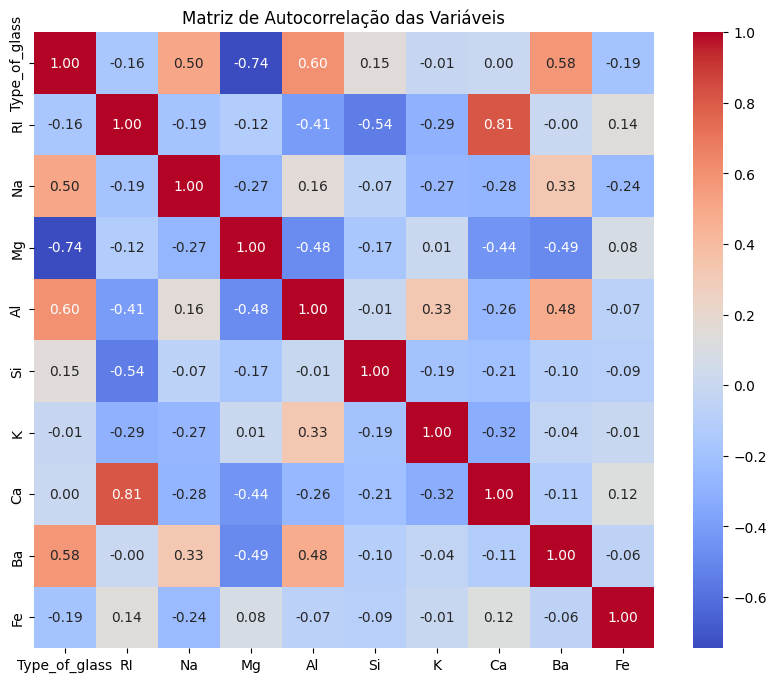

In [7]:
# Calcular a matriz de correlação
correlation_matrix = glass_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Autocorrelação das Variáveis')
plt.show()

Temos uma alta correlação positiva entre as variáveis RI e Ca. No geral, o dataset não parece estar sobrepondo informações, podemos avaliar todas as variáveis com segurança. O próximo passo será tentar fazer uma análise visual dos dados. Portanto, é criado um DF com a média de cada componente por tipo de vidro. Desta forma, conseguimos visualizar o que compões melhor cada tipo.

In [8]:
#crianfo um DF da média de cada elemento por tipo de vidro:
mean_elements = glass_data.groupby('Type_of_glass',as_index=False).mean()
mean_elements = pd.melt(mean_elements, id_vars=['Type_of_glass'], value_vars=['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe'])
mean_elements['value'] = mean_elements['value']*100
mean_elements.head(10)

,Type_of_glass,variable,value
0,1,RI,33.223379
1,2,RI,32.785569
2,3,RI,29.910138
3,5,RI,34.142635
4,6,RI,27.680226
5,7,RI,26.190548
6,1,Na,37.778733
7,2,Na,35.815196
8,3,Na,40.707651
9,5,Na,31.544245


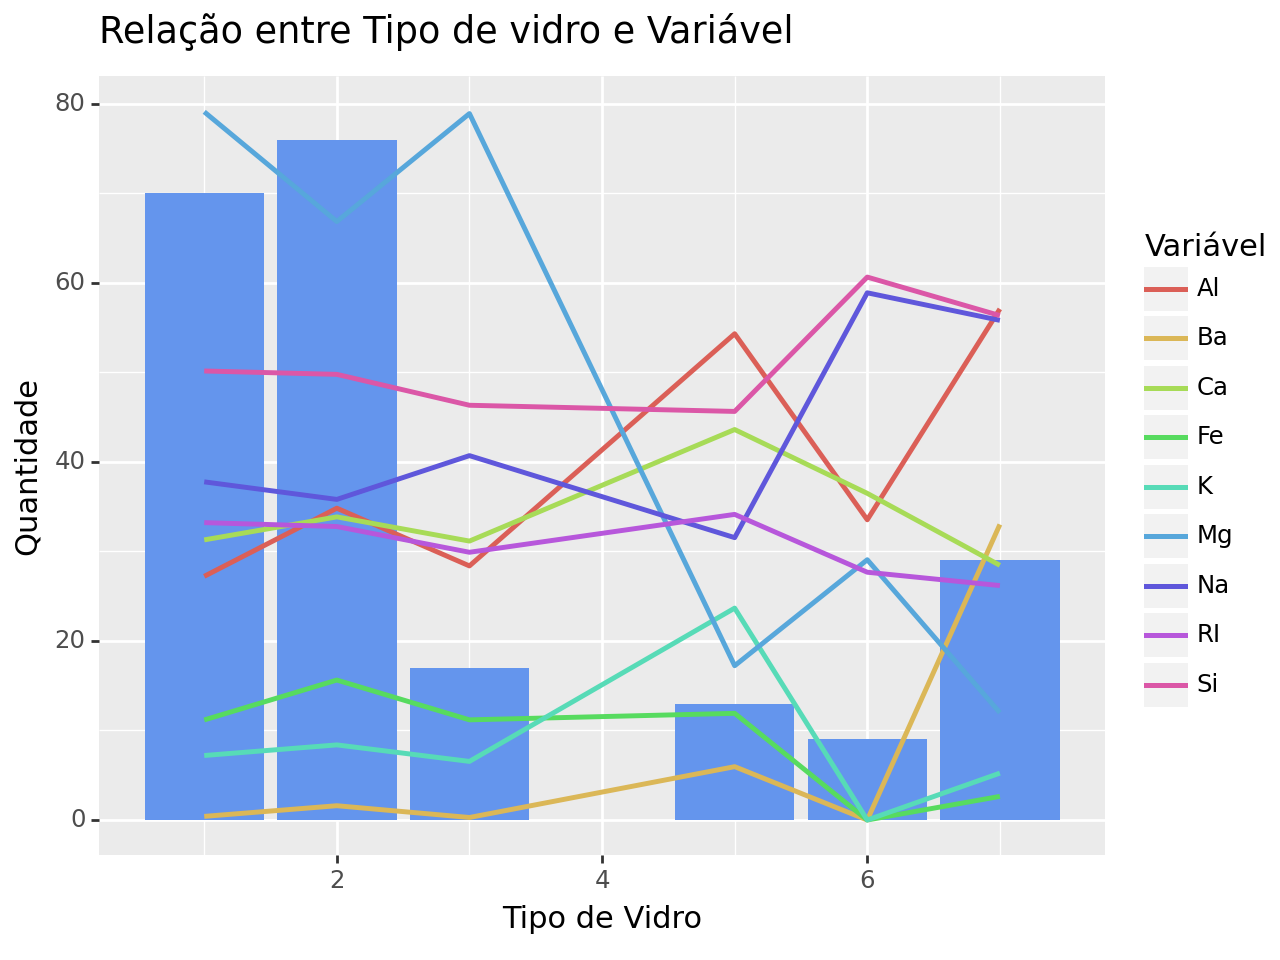

<Figure Size: (640 x 480)>

In [9]:
# plot
(
    ggplot(glass_data) +
   geom_bar(aes("Type_of_glass"),fill="cornflowerblue") +
    geom_line(mean_elements,aes(x="Type_of_glass", y="value",colour="variable"),stat="identity",size=1) +
    labs(title="Relação entre Tipo de vidro e Variável",x="Tipo de Vidro",y="Quantidade",colour="Variável") +
   theme_set(theme_bw())
)

No gráfico acima, podemos notar que há um grande desbalanceamento na quantidade de vidros em cada tipo, uma relação que a variável K (potássio) é muito presente nos tipos de 1 a 3 e não tão presente nos tipos de 5 a 7. De modo geral, o gráfico ajuda a visualizar a importância de alguns atributos em relação à outros.

## Seleção de atributos

 ​​Para selecionar os atributos que tenham a relação mais forte com a variável de saída, vamos utilizar dois métodos de classificações de variáveis:

O SelectKBest é  uma seleção univariada, que usa o teste Análise de Variância (ANOVA), neste teste, o teste F é aplicado para avaliar se há diferenças significativas nas médias entre os grupos de acordo com a variável categórica.

O *ExtraTreesClassifier* é um classificador de *ensemble* baseado em árvores de decisão, que utiliza uma técnica conhecida como "*Extremely Randomized Trees*".


Após esses dois métodos, vamos comparar os métodos *foward* e *backward* selection e com a análise visual já realizada.

In [10]:
# Importância dos atributos utilizando o SelectKBest
y = glass_target.values
X = glass_data[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']]

best_var = SelectKBest(score_func=f_classif,k='all')
fit = best_var.fit(X, y)

sorted_features_selection = sorted(zip(glass_data.columns[1:10], fit.scores_), key=lambda x: x[1], reverse=True)
print("Importância das features com o SelectKBest:")
for col, imp in sorted_features_selection:
    print(f"{col}: {round(imp,4)}")

Importância das features com o SelectKBest:
Mg: 65.5445
Ba: 38.9746
Al: 35.7267
Na: 28.548
K: 8.7481
Ca: 2.9714
Si: 2.7873
Fe: 2.7109
RI: 1.609


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [11]:
# Importância de Atributos com ExtraTrees
modelo = ExtraTreesClassifier(n_estimators=50)
modelo.fit(X,y.ravel())

sorted_features_selection = sorted(zip(glass_data.columns[1:10], modelo.feature_importances_), key=lambda x: x[1], reverse=True)
print("Importância das features com ExtraTrees:")
for col, imp in sorted_features_selection:
    print(f"{col}: {round(imp,4)}")


Importância das features com ExtraTrees:
Mg: 0.1882
Al: 0.1466
RI: 0.1395
Ca: 0.1213
K: 0.0996
Na: 0.0941
Si: 0.0905
Ba: 0.0663
Fe: 0.0539


In [12]:
forward_selection(X,y.ravel(),modelo)
backward_selection(X,y.ravel(),modelo)

Variáveis selecionadas com o Foward:  ['Al', 'RI', 'Mg', 'Ca', 'K']
Variáveis selecionadas com o Backward:  ['RI', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Ba', 'Fe']


Podemos perceber que existe uma divergência entre os métodos utilizados para a seleção. Algumas possíveis variáveis para o modelo foram divergentes em cada método. Por exemplo, a variável 'Mg' que possui  o maior escore no método de importancia de features pelo ExtraTreesClassifier, não apareceu como feature selecionada no método Backward. Desta forma, utilizando a análise visual do gráfico com a média das componentes, e também com os escores observados, as fetures escolhidas para o modelo inicial serão:

'RI', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Ba'

Ou seja, estamos tirando apenas 'Fe' e 'Si'

# Modelagem

In [13]:
X = (glass_data[['RI', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Ba']])
# y já selecionamos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.ravel())



X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25,stratify=y_encoded, random_state=384765)
kfold = KFold(n_splits=5, shuffle=True, random_state=384765)

A validação cruzada, vai nos ajudar a fazer uma estimativa mais robusta do desempenho do modelo, ajuda a reduzir a variância e avalia a capacidade geral do modelo, além de ajudar a evitar o overfitting.

XGB - média: 0.712500 desvio padrão: 0.053765
SVM - média: 0.568750 desvio padrão: 0.089268
RFC - média: 0.750000 desvio padrão: 0.071261
LogReg - média: 0.506250 desvio padrão: 0.072349


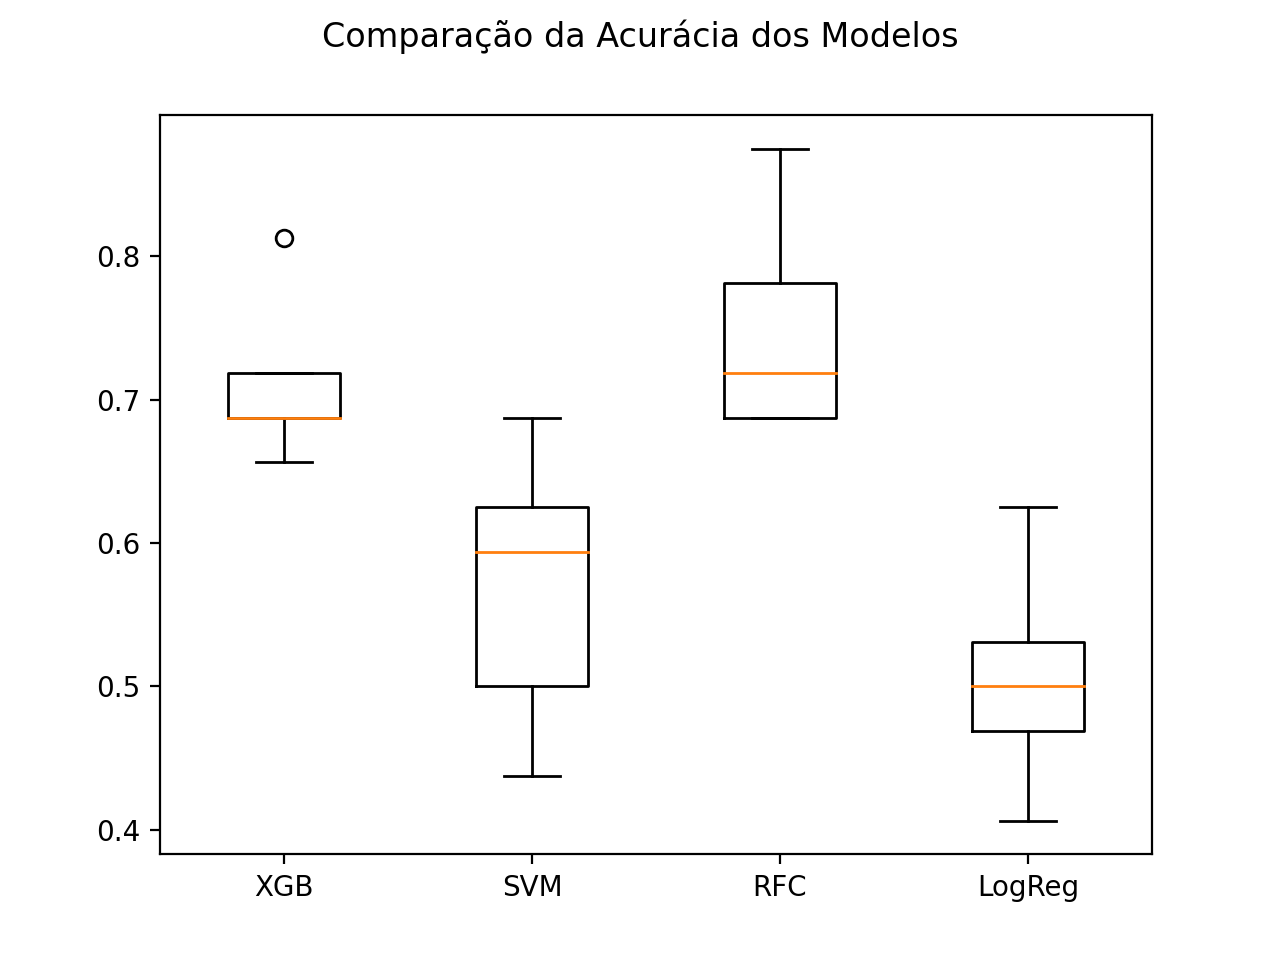

In [14]:
np.random.seed(7384765)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista

models.append(('XGB', XGBClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('LogReg', LogisticRegression(max_iter=5000)))


#  o modelo de regressão logística automaticamente atribui pesos às classes de forma inversamente proporcional
#  às suas frequências, o que ajuda a lidar com conjuntos de dados desbalanceados. Isso pode resultar em um desempenho melhor do modelo, especialmente para a classe minoritária.
# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s - média: %f desvio padrão: %f" % (name, cv_results.mean(), cv_results.std())
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Usando o GridSearch para otimização dos hiperparametros

Uma das formas de melhorar esses modelos é de encontrar os melhores valores de hiperparametros para cada, realizando testes em cada subsample e fazendo validações para verificar a acurácia. Aqui, todos os 4 modelos escolhidos, XGBoost, Support Vector Machine, Random Forest e Regressão Logística estarão sendo otimizados.

Observação: as hiperparametrizações foram realizadas em código, porém, como muitas delas tem um custo computacional muito elevado, estou representando em texto os códigos utilizados.


### Regressão Logística

```
logModel = LogisticRegression()

param_grid = [
    {'penalty' : ['l2',None],
    'C' : np.logspace(-2, 2, 20),
    'solver' : ['lbfgs','newton-cg','sag','saga'],
    'max_iter' : [500,1000, 2500, 5000]
    }
]

clf = GridSearchCV(logModel, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

```


>  {'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}







### XGBoost
```
xgb_model = XGBClassifier()
param_grid = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.01, 0.05],
              'max_depth': [2,5,10],
              'min_child_weight':  [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': [60,100,200]}

clf = GridSearchCV(xgb_model, param_grid = param_grid, n_jobs=-1, cv=5, verbose=True)

best_clf = clf.fit(X_train,y_train)
best_clf.best_params_
```


> {'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 60,
 'nthread': 4,
 'objective': 'binary:logistic',
 'subsample': 0.6}

{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic',
 'subsample': 0.8}





### Random Forest
```
rf_model = RandomForestClassifier()
param_grid = {
'n_estimators':[50,100,150],
'max_depth': [None,10,20],
'min_samples_split': [2,5,10],
'max_features':['sqrt','log2']
}

clf = GridSearchCV(rf_model, param_grid = param_grid, n_jobs=-1, cv=5, verbose=True)

best_clf = clf.fit(X_train,y_train)
best_clf.best_params_
```


>{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 50}






### SVM
```
svm_model = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly','sigmoid'],
              'class_weight':['balanced',None]}

clf = GridSearchCV(svm_model, param_grid = param_grid, n_jobs=-1, cv=5, verbose=True)

best_clf = clf.fit(X_train,y_train)
best_clf.best_params_
```


{'C': 1000, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'poly'}



XGB - média: 0.712500 desvio padrão: 0.087052
SVM - média: 0.718750 desvio padrão: 0.094786
RFC - média: 0.725000 desvio padrão: 0.057282
LogReg - média: 0.550000 desvio padrão: 0.075519


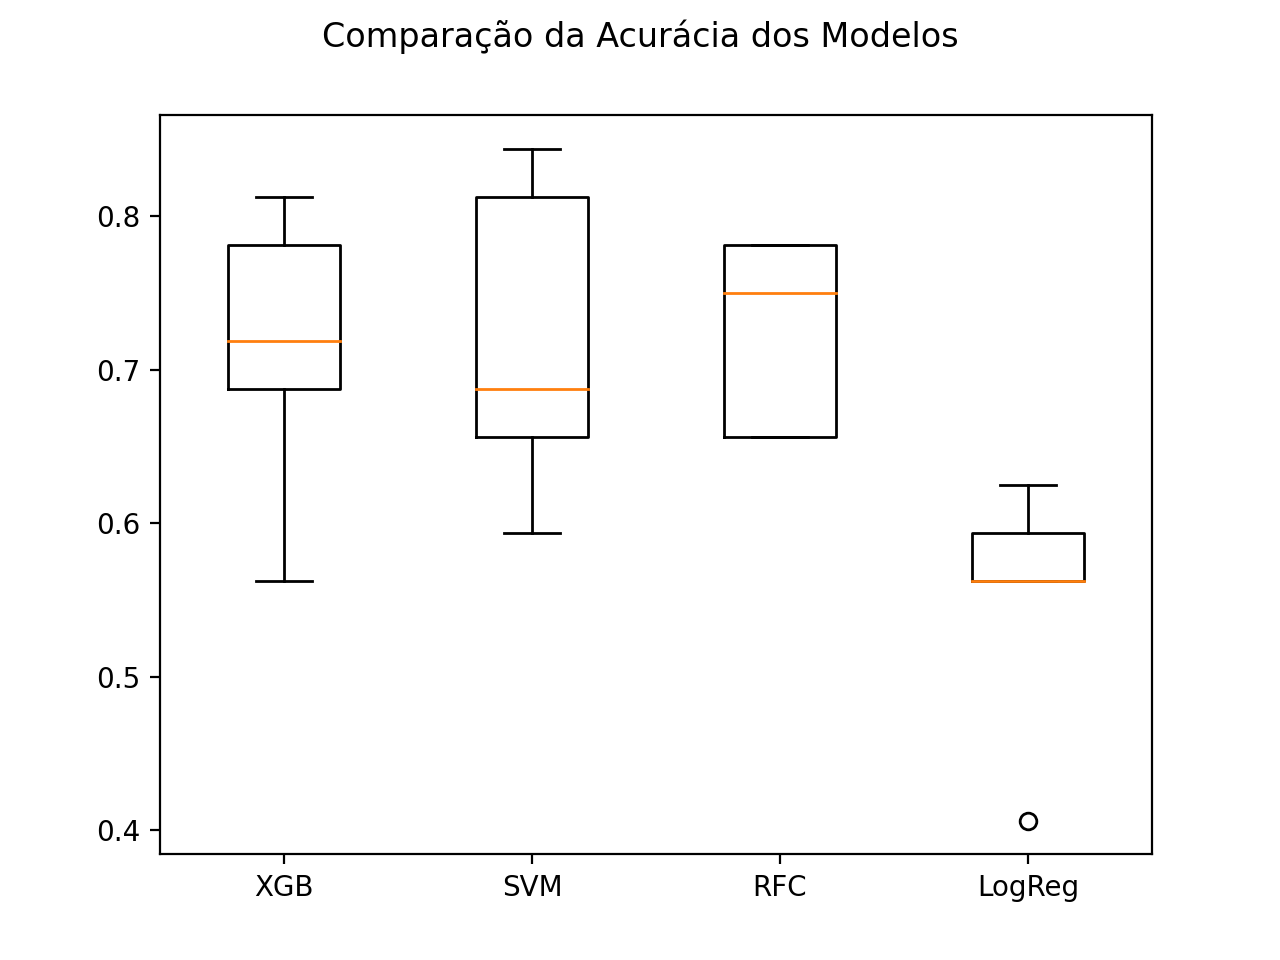

In [15]:
models = []
results = []
names = []

models.append(('XGB', XGBClassifier(colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200,
 nthread=4, objective='binary:logistic', subsample=0.8)))

models.append(('SVM', SVC(C=1000,gamma=1,kernel='poly', class_weight='balanced')))

models.append(('RFC', RandomForestClassifier(max_depth=10,  max_features='sqrt', min_samples_split=5, n_estimators=50)))

models.append(('LogReg', LogisticRegression(C=1, max_iter=100, penalty= 'l2', solver= 'liblinear',class_weight='balanced')))


for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s - média: %f desvio padrão: %f" % (name, cv_results.mean(), cv_results.std())
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [16]:
print(results)

[array([0.72, 0.78, 0.56, 0.81, 0.69]), array([0.59, 0.81, 0.66, 0.84, 0.69]), array([0.66, 0.78, 0.66, 0.78, 0.75]), array([0.56, 0.59, 0.41, 0.56, 0.62])]
